## Mag _versus_ Fofa challenge!

This is based on fast.ai lesson1 notebook.

**Data is not here**.

Unfortunately, I cannot make those photos public, as they involve too much of my intimate life.
If you happen to have two cats of other two pets, just create `train` and `valid` folder with their photos in separate
subfolders, change the PATH variable and you are probably set.

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import random

PATH = "datalab/mag-fofa/"
sz=299
arch=resnext50
bs=28

In [17]:
%ls datalab/

mag-fofa/


Let's take a look in some examples.

In [53]:
#Fofa examples:
fofas = random.sample(os.listdir(f'{PATH}/valid/fofa'), 5)
fofas

['129.jpeg',
 'IMG_20171205_200706.jpg',
 'IMG_20170425_115925_990.jpg',
 'IMG_20171226_071928.jpg',
 '225.jpeg']

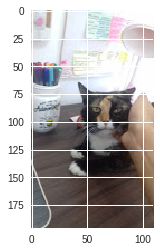

In [54]:
img = plt.imread(f'{PATH}valid/fofa/{fofas[0]}')
plt.imshow(img);


In [55]:
#Mag examples:
mags = random.sample(os.listdir(f'{PATH}/valid/mag'),5)
mags

['303.jpeg',
 '078.jpeg',
 'IMG_20180403_082210.jpg',
 'IMG_20180322_221805.jpg',
 'IMG_20180410_063449_HHT.jpg']

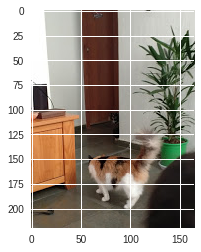

In [56]:
img = plt.imread(f'{PATH}valid/mag/{mags[0]}')
plt.imshow(img);

## The magic happens here


In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


In [33]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.353918   0.188734   0.911765  



In [34]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.142252   0.131246   0.941176  
    1      0.124358   0.129656   0.941176  



[array([0.12966]), 0.9411764705882353]

In [0]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [36]:
%time learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.170392   0.17959    0.941176  
    1      0.114434   0.220459   0.955882  
    2      0.093939   0.230702   0.941176  

CPU times: user 8min 38s, sys: 36.5 s, total: 9min 14s
Wall time: 4min 57s


[array([0.2307]), 0.9411764495513019]

In [0]:
learn.save('224_all_50')

In [0]:
learn.load('224_all_50')

In [39]:
log_preds,y = learn.TTA()
probabilities = np.mean(np.exp(log_preds),0)
accuracy_np(probabilities,y)

0.9705882352941176

## Analyzing results

In [0]:
preds = np.argmax(probabilities, axis=1)
probs = probabilities[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [41]:
# what is y?
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [42]:
# which classes do we have and what are their indices?
data.classes

['fofa', 'mag']

[[35  1]
 [ 1 31]]


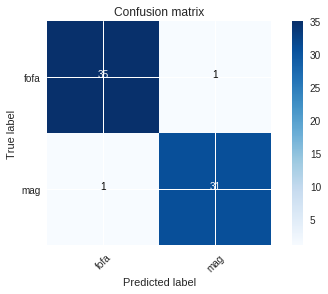

In [43]:
plot_confusion_matrix(cm, data.classes)

In [44]:
# Where did the algorithm got right?
data.val_y == preds

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = ["Fofa: %.2f " % probabilities[x][0] + "Mag: %.2f" % probabilities[x][1] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)


Corretos


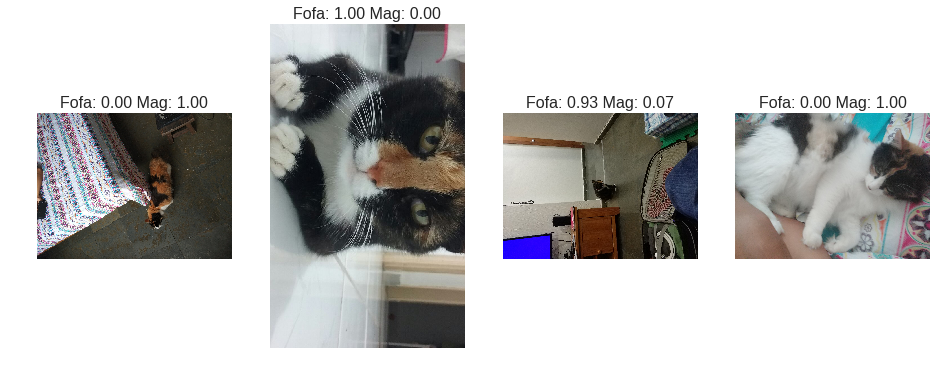

In [46]:
plot_val_with_title(rand_by_correct(True), "Corretos")

The Incorrect photos


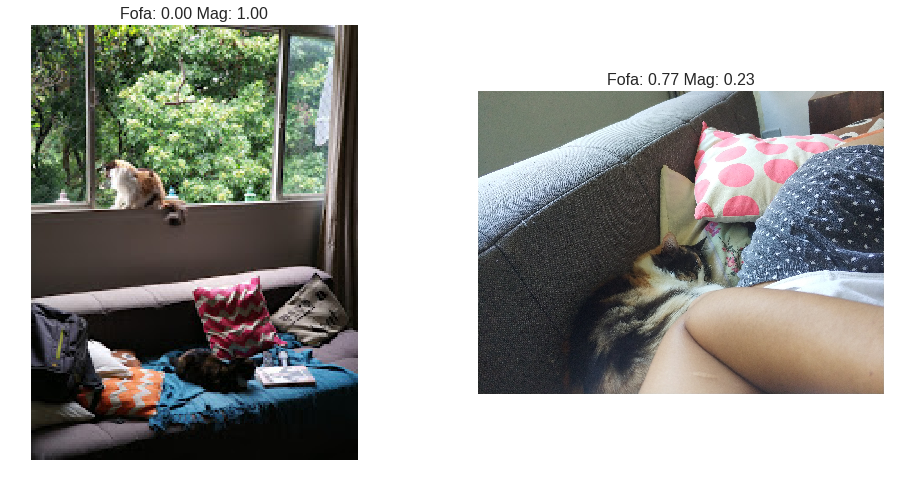

In [50]:
plot_val_with_title(most_by_correct(0, False), "The Incorrect photos")